In [1]:
%run ../0-utils/0-Base.ipynb

Define a dataset:

In [2]:
from torch.utils.data import Dataset

class EloDataset(Dataset):
    def __init__(self, clazz):
        self.clazz = clazz
        
        if clazz == "train":
            self.X = np.load("../data/2-feature-engineered/X_train.npy").astype(np.float32)
            self.y = np.load("../data/2-feature-engineered/y_train.npy").astype(np.float32)
        
        if clazz == "test":
            self.X = np.load("../data/2-feature-engineered/X_test.npy").astype(np.float32)
        
    def __len__(self): return self.X.shape[0]
    
    def __getitem__(self, index):
        if self.clazz == "train":
            return self.X[index], self.y[index]
        
        if self.clazz == "test":
            return self.X[index]

Define *train* and *test* data loaders:

In [3]:
from sklearn.model_selection import train_test_split

from torch.utils.data import DataLoader, SequentialSampler

dataset = EloDataset("train")

train_idx, valid_idx = train_test_split(np.arange(len(dataset)), random_state=13)

train_sampler = SequentialSampler(train_idx)
valid_sampler = SequentialSampler(valid_idx)

train_loader = DataLoader(dataset, sampler=train_sampler, batch_size=16)
valid_loader = DataLoader(dataset, sampler=valid_sampler, batch_size=2048)

Define a device that will be used for training / evaluation:

In [4]:
import torch

np.random.seed(13)
torch.manual_seed(13)

torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

device = "cuda" if torch.cuda.is_available() else "cpu"

In [5]:
from torch import nn

import torch.nn.functional as F

class Regressor(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.lstm = nn.LSTM(input_size=9,
                            hidden_size=64,
                            num_layers=2,
                            dropout=0.5,
                            batch_first=True)
        
        self.fc1 = nn.Linear(64, 32)
        self.fc2 = nn.Linear(32, 1)
        
        self.dropout = nn.Dropout()
        
    def forward(self, x):
        x, _ = self.lstm(x, None)

        x = x[:, -1]
#         x = self.dropout(x)
        
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        
        x = self.fc2(x)
        
        return x

In [6]:
from torch import optim
from tqdm.auto import tqdm

model = Regressor().to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

step = 0
n_epochs = 15
log_every_n_steps = 150

cum_train_loss = 0.
valid_loss_min = np.Inf
train_losses, valid_losses = [], []

for epoch in tqdm(range(n_epochs)):
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        
        y_pred = model.forward(x)
        y_pred = y_pred.reshape(-1)
        loss = criterion(y_pred, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        cum_train_loss += loss.item()
        
        if step and step % log_every_n_steps == 0:
            cum_valid_loss = 0.
            
            model.eval()
            
            with torch.no_grad():
                for x, y in valid_loader:
                    x, y = x.to(device), y.to(device)
                    
                    y_pred = model.forward(x)
                    y_pred = y_pred.reshape(-1)
                    loss = criterion(y_pred, y)
                    
                    cum_valid_loss += loss.item()
            
            model.train()

            train_loss = (cum_train_loss / log_every_n_steps) ** 0.5
            valid_loss = (cum_valid_loss / len(valid_loader)) ** 0.5
    
            if valid_loss < valid_loss_min:
                print("Validation loss decreased: %.4f => %.4f | Saving model..." % (valid_loss_min, valid_loss))
                torch.save(model.state_dict(), "model.pt")
                valid_loss_min = valid_loss
    
            train_losses.append(train_loss)
            valid_losses.append(valid_loss)
            
            cum_train_loss = 0.
        
        step += 1

Validation loss decreased: inf => 7.6160 | Saving model...
Validation loss decreased: 7.6160 => 7.4410 | Saving model...
Validation loss decreased: 7.4410 => 7.4079 | Saving model...
Validation loss decreased: 7.4079 => 7.3520 | Saving model...
Validation loss decreased: 7.3520 => 7.3117 | Saving model...
Validation loss decreased: 7.3117 => 7.2977 | Saving model...
Validation loss decreased: 7.2977 => 7.2918 | Saving model...
Validation loss decreased: 7.2918 => 7.2708 | Saving model...
Validation loss decreased: 7.2708 => 7.2553 | Saving model...
Validation loss decreased: 7.2553 => 7.2506 | Saving model...
Validation loss decreased: 7.2506 => 7.2485 | Saving model...
Validation loss decreased: 7.2485 => 7.2472 | Saving model...
Validation loss decreased: 7.2472 => 7.2427 | Saving model...
Validation loss decreased: 7.2427 => 7.2426 | Saving model...
Validation loss decreased: 7.2426 => 7.2422 | Saving model...
Validation loss decreased: 7.2422 => 7.2408 | Saving model...
Validation 

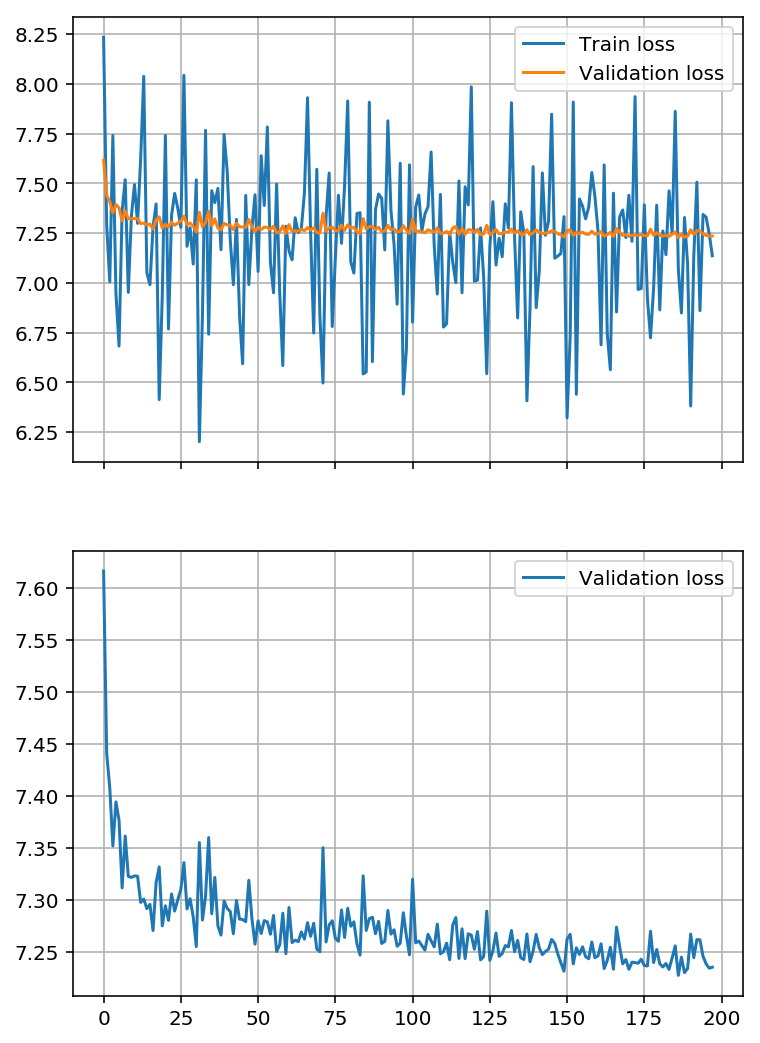

In [7]:
_, axs = plt.subplots(2, 1, figsize=(6, 9), sharex=True)

axs[0].plot(train_losses, label="Train loss")
axs[0].plot(valid_losses, label="Validation loss")
axs[0].legend()
axs[0].grid()

axs[1].plot(valid_losses, label="Validation loss")
axs[1].legend()
axs[1].grid()

plt.show()

In [8]:
dataset = EloDataset("test")

test_loader = DataLoader(dataset, batch_size=2048)

model = Regressor().to(device).eval()
model.load_state_dict(torch.load("model.pt"))

y_test = []

with torch.no_grad():
    for x in tqdm(test_loader):
        x = x.to(device)

        y_pred = model.forward(x)
        y_test.append(y_pred.cpu().numpy())

RuntimeError: input.size(-1) must be equal to input_size. Expected 9, got 3

In [ ]:
y_test = np.concatenate(y_test); y_test

In [ ]:
submission_df = pd.read_csv("../data/raw/sample_submission.csv")
submission_df.target = y_test
submission_df

In [ ]:
submission_df.to_csv("../submission.csv", index=False)